# Import Modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import utils

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare Data

In [3]:
# source_X: shape of (N_source, D)
# source_y_domain: (N_source, 1)
# source_y_task: (N_source, 1)
# source_Y: (N_source, 2)

# target_X: (N_target, D)
# target_y_domain: (N_target, )
# target_y_task: (N_target, )

source_X, target_X, source_y_task, target_y_task, x_grid, x1_grid, x2_grid = utils.get_source_target()

source_y_domain = np.zeros_like(source_y_task).reshape(-1, 1)
source_y_task = source_y_task.reshape(-1, 1)

source_Y = np.concatenate([source_y_task, source_y_domain], axis=1)
target_y_domain = np.ones_like(target_y_task)

print(f"N_source: {source_X.shape[0]}")
print(f"D: {source_X.shape[1]}\n")

print(f"source_X: {source_X.shape}")
print(f"source_y_domain: {source_y_domain.shape}")
print(f"source_y_task: {source_y_task.shape}")
print(f"source_Y: {source_Y.shape}\n")

print(f"N_target: {target_X.shape[0]}")
print(f"target_X: {target_X.shape}")
print(f"target_y_domain: {target_y_domain.shape}")
print(f"target_y_task: {target_y_task.shape}")

N_source: 100
D: 2

source_X: (100, 2)
source_y_domain: (100, 1)
source_y_task: (100, 1)
source_Y: (100, 2)

N_target: 100
target_X: (100, 2)
target_y_domain: (100,)
target_y_task: (100,)


In [4]:
source_X = torch.tensor(source_X, dtype=torch.float32)
source_Y = torch.tensor(source_Y, dtype=torch.float32)
target_X = torch.tensor(target_X, dtype=torch.float32)
target_y_domain = torch.tensor(target_y_domain, dtype=torch.float32)
target_y_task = torch.tensor(target_y_task, dtype=torch.float32)

source_X = source_X.to(device)
source_Y = source_Y.to(device)
target_X = target_X.to(device)
target_y_domain = target_y_domain.to(device)
target_y_task = target_y_task.to(device)

source_ds = TensorDataset(source_X, source_Y)
target_ds = TensorDataset(target_X, target_y_domain)

source_loader = DataLoader(source_ds, batch_size=34, shuffle=True)
target_loader = DataLoader(target_ds, batch_size=34, shuffle=True)

In [5]:
source_X_eval, source_y_task_eval, target_X_eval = source_X.clone(), source_y_task.copy(), target_X.clone()
# TODO: Refactoring(with respect to updated target_X, source_X, source_y_task)

# Instantiate Feature Extractor, Domain Classifier, Task Classifier

In [6]:
class Encoder(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, output_size)

    def forward(self, x):
        return F.relu(self.fc1(x))

In [7]:
class Decoder(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
hidden_size = 10
num_domains = 1
num_classes = 1
dropout_ratio = 0.5

feature_extractor = Encoder(input_size=source_X.shape[1], output_size=hidden_size).to(device)
domain_classifier = Decoder(input_size=hidden_size, output_size=num_domains).to(device)
task_classifier = Decoder(input_size=hidden_size, output_size=num_classes).to(device)

In [9]:
learning_rate = 0.001

criterion = nn.BCELoss()
feature_optimizer = optim.Adam(feature_extractor.parameters(), lr=learning_rate)
domain_optimizer = optim.Adam(domain_classifier.parameters(), lr=learning_rate)
task_optimizer = optim.Adam(task_classifier.parameters(), lr=learning_rate)

# Domain Invariant Learning

In [10]:
class ReverseGradient(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return input
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output * -1

reverse_grad = ReverseGradient.apply
# TODO: Understand torch.autograd.Function.apply

In [11]:
num_epochs = 1000
# Parameters: source_loader, target_loader, num_epochs

for _ in range(num_epochs):
    for (source_X, source_Y), (target_X, target_y_domain) in zip(source_loader, target_loader):
        # 0. Data
        source_X = source_X.to(device)
        source_y_task = source_Y[:, 0].to(device)
        source_y_domain = source_Y[:, 1].to(device)
        target_X = target_X.to(device)
        target_y_domain = target_y_domain.to(device)

        # 1. Forward
        # 1.1 Feature Extractor
        source_X, target_X = feature_extractor(source_X), feature_extractor(target_X)

        # 1.2. Task Classifier
        pred_y_task = task_classifier(source_X)
        pred_y_task = torch.sigmoid(pred_y_task).reshape(-1)
        loss_task = criterion(pred_y_task, source_y_task)

        # 1.3. Domain Classifier
        source_X, target_X = reverse_grad(source_X), reverse_grad(target_X)
        pred_source_y_domain, pred_target_y_domain = domain_classifier(source_X), domain_classifier(target_X)
        pred_source_y_domain, pred_target_y_domain = torch.sigmoid(pred_source_y_domain).reshape(-1), torch.sigmoid(pred_target_y_domain).reshape(-1)

        loss_domain = criterion(pred_source_y_domain, source_y_domain)
        loss_domain += criterion(pred_target_y_domain, target_y_domain)

        # 2. Backward, Update Params
        domain_optimizer.zero_grad()
        task_optimizer.zero_grad()
        feature_optimizer.zero_grad()

        loss_domain.backward(retain_graph = True)
        loss_task.backward() 
        
        domain_optimizer.step()
        task_optimizer.step()
        feature_optimizer.step()
    # 4. Evaluation

# Domain Adaptation Accuracy

In [12]:
target_feature_eval = feature_extractor(target_X_eval)
pred_y_task = task_classifier(target_feature_eval)
pred_y_task = torch.sigmoid(pred_y_task).reshape(-1)
pred_y_task = pred_y_task > 0.5

acc = sum(pred_y_task == target_y_task) / target_y_task.shape[0]
print(f"Accuracy:{acc}")

Accuracy:0.9300000071525574


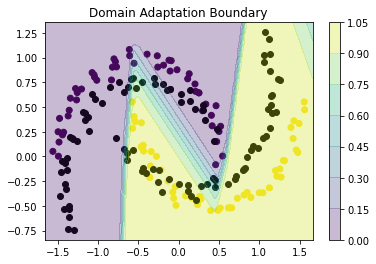

In [13]:
source_X_eval = source_X_eval.cpu()
target_X_eval = target_X_eval.cpu()
target_y_task = target_y_task.cpu()

x_grid = torch.tensor(x_grid, dtype=torch.float32)
x_grid = x_grid.to(device)

x_grid = feature_extractor(x_grid.T)
y_grid = task_classifier(x_grid)
y_grid = torch.sigmoid(y_grid)
y_grid = y_grid.cpu().detach().numpy()

plt.title("Domain Adaptation Boundary")
plt.scatter(source_X_eval[:, 0], source_X_eval[:, 1], c=source_y_task_eval)
plt.scatter(target_X_eval[:, 0], target_X_eval[:, 1], c="black")
plt.contourf(x1_grid, x2_grid, y_grid.reshape(100, 100), alpha=0.3)
plt.colorbar()

# Without Adaptation